This is not actually asked in the assignment, but done just to check how masking the grey scale images with NaN values affect the loss when using matrix factorization. 

Can be ignored for grading 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

mps


In [2]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("image.jpg")
print(img.shape)


torch.Size([3, 4000, 6000])


In [3]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([4000, 6000])


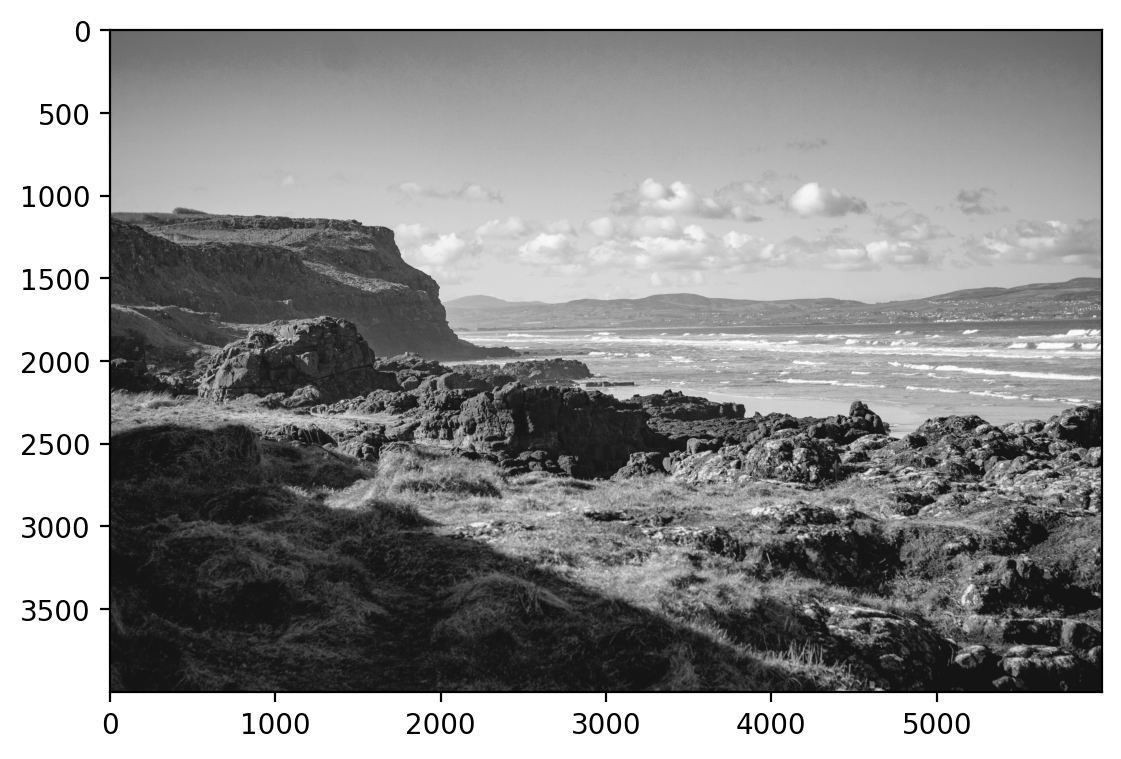

In [4]:
plt.imshow(img, cmap='gray')

In [5]:
crop = torchvision.transforms.functional.crop(img, 1650, 500, 700, 1200)
crop.shape

torch.Size([700, 1200])

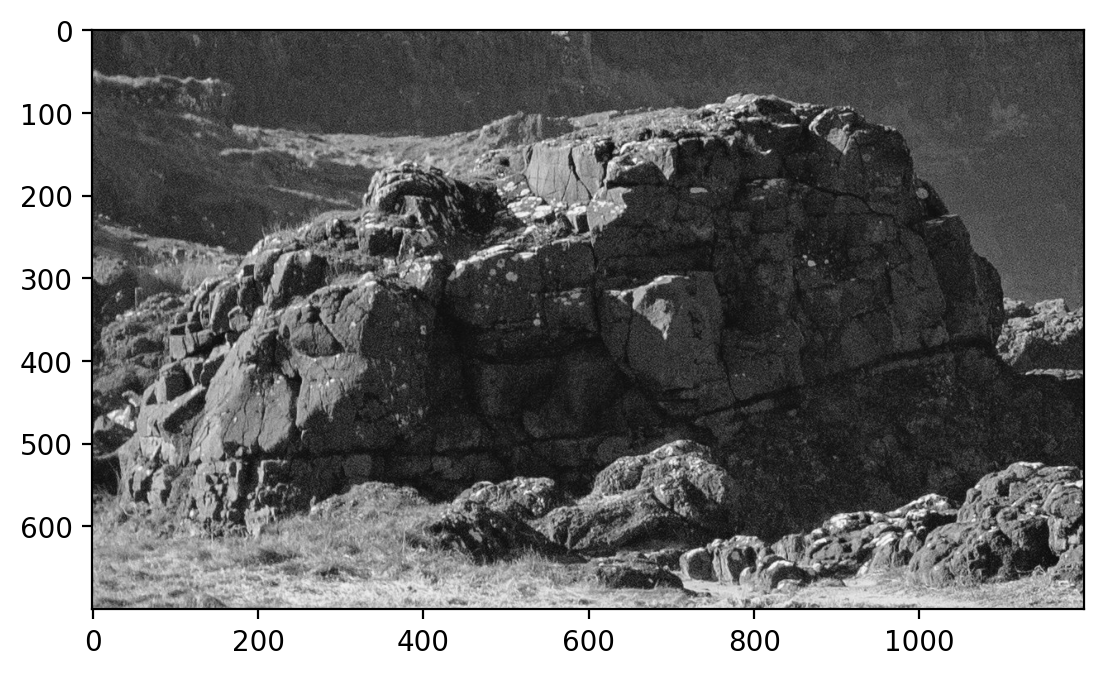

In [6]:
plt.imshow(crop, cmap='gray')

In [7]:
# Function to mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

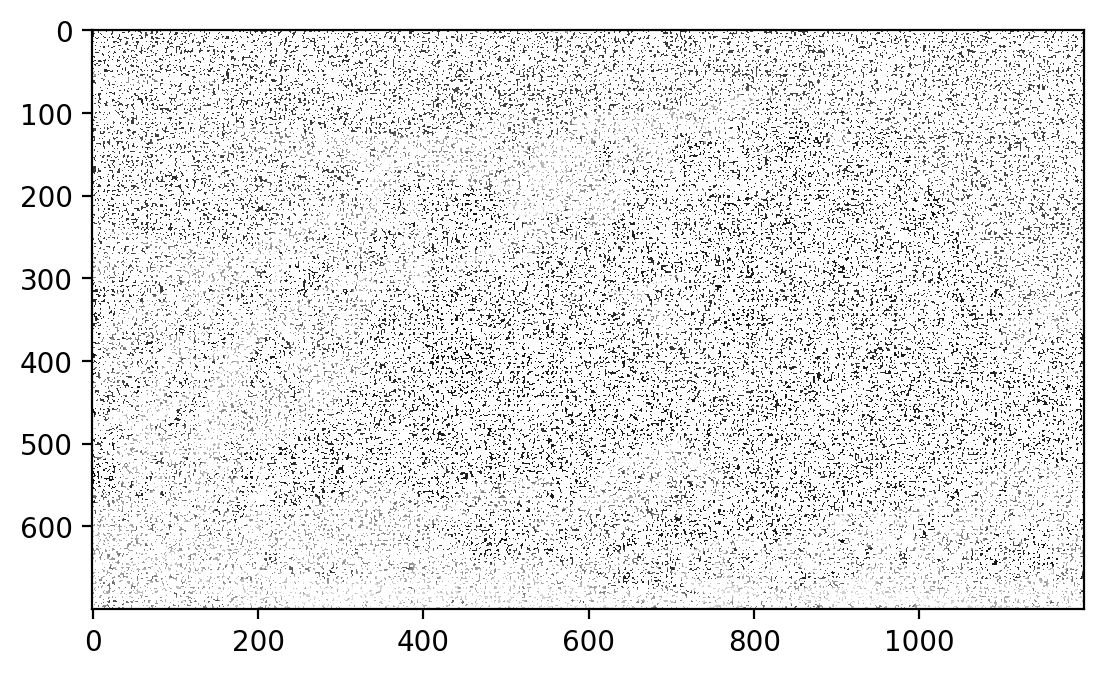

In [8]:
masked_img = mask_image(crop, 0.3)
# masked_img[0], masked_img[1]
plt.imshow(masked_img[0], cmap='gray')

In [9]:
# Modify the loss function to ignore NaN values
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [10]:
for k in [10, 20, 30, 40, 50, 60, 70]:
    W, H, loss = factorize(masked_img[0], k, device=device)
    print(k, loss.item())

10 23403.185546875
20 18793.08984375
30 15991.1748046875
40 14019.296875
50 12638.140625
60 11603.3095703125
70 10710.466796875


In [11]:
torch.isnan(masked_img[0]).sum().item()

251795

In [12]:
for k in [10, 20, 30, 40, 50, 60, 70]:
    W, H, loss = factorize(crop, k, device=device)
    print(k, loss.item())

10 28720.109375
20 22803.830078125
30 19320.103515625
40 17138.28125
50 15495.62109375
60 14192.501953125
70 13164.927734375


In [13]:
W, H, loss = factorize(masked_img[0], 70, device=device)

In [14]:
loss, W.shape, H.shape

(tensor(10650.9375, device='mps:0', grad_fn=<NormBackward1>),
 torch.Size([700, 70]),
 torch.Size([70, 1200]))

Text(0.5, 1.0, 'Reconstructed Image With Missing Values')

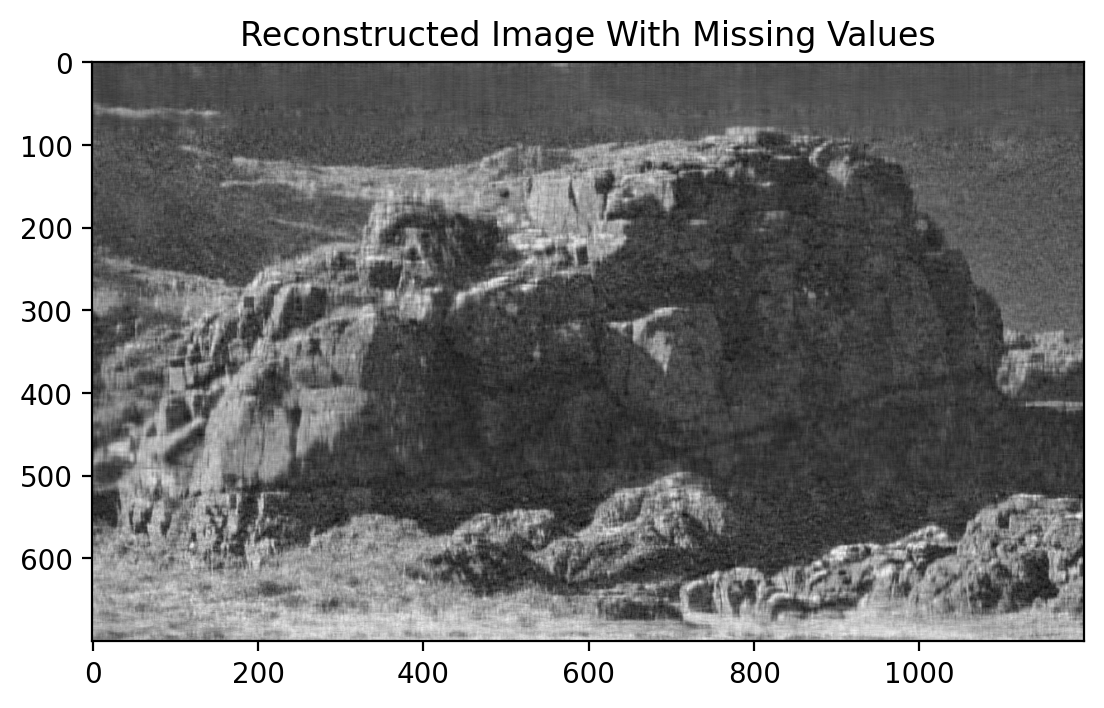

In [15]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')
plt.title("Reconstructed Image With Missing Values")

In [16]:
W, H, loss = factorize(crop, 70, device=device)

In [17]:
loss, W.shape, H.shape

(tensor(13183.1143, device='mps:0', grad_fn=<NormBackward1>),
 torch.Size([700, 70]),
 torch.Size([70, 1200]))

Text(0.5, 1.0, 'Reconstructed Image Without Missing Values')

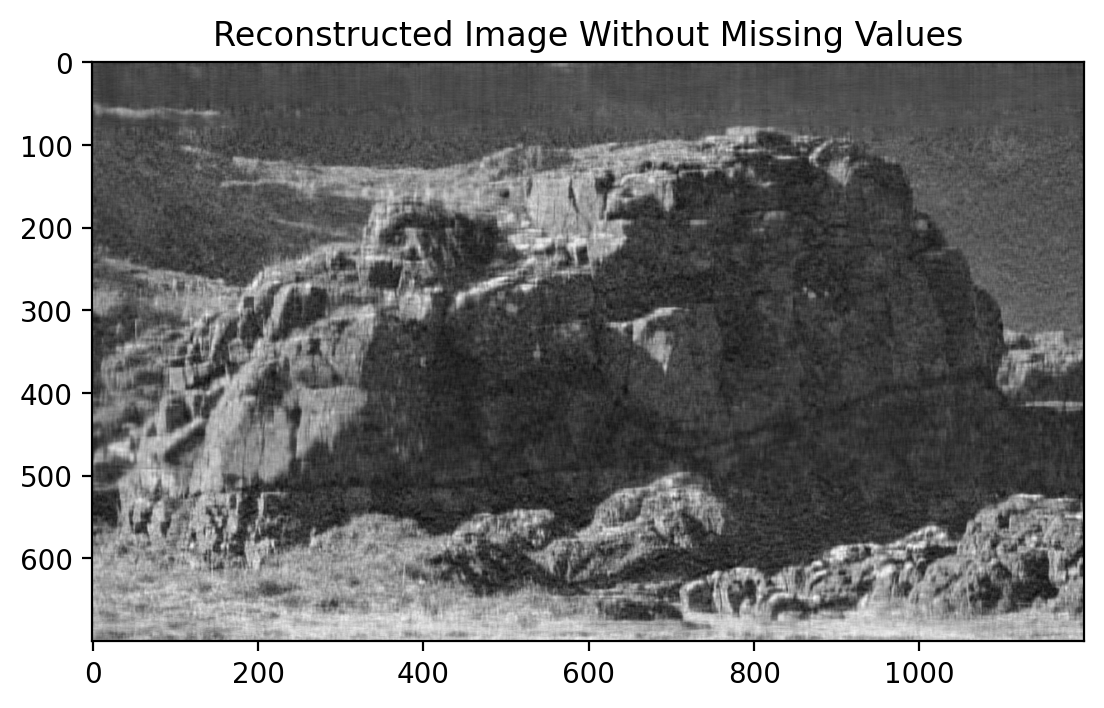

In [18]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray',)
plt.title("Reconstructed Image Without Missing Values")